In [26]:
# Cell 1 ──────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("scan_wide.csv")
df.head()


,beta,alpha,mean_cos,std_cos,susceptibility
0,0.8,0.0,0.002940,0.042125,0.489763
1,0.8,0.1,0.004585,0.038150,0.401698
2,0.8,0.2,0.329140,0.111329,3.420764
3,0.8,0.3,0.272311,0.165672,7.575440
4,0.8,0.4,0.270427,0.176502,8.598215


In [27]:
# Cell 2 ──────────────────────────────────────────────────────────────
# Handy pivot tables for 2‑D plots
pivot_meancos = df.pivot(index="beta", columns="alpha", values="mean_cos")
pivot_chi     = df.pivot(index="beta", columns="alpha", values="susceptibility")

# quick sanity check
print("Shape:", pivot_meancos.shape)


Shape: (29, 31)


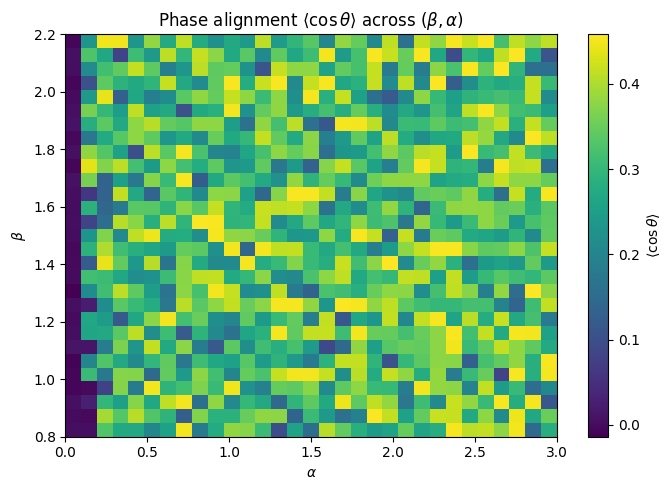

In [28]:
# Cell 3 ──────────────────────────────────────────────────────────────
# Heat‑map of 〈cos θ〉 over the (β, α) plane
plt.figure(figsize=(7, 5))
plt.imshow(pivot_meancos.values,
           origin="lower",
           aspect="auto",
           extent=[df["alpha"].min(), df["alpha"].max(),
                   df["beta"].min(),  df["beta"].max()])
plt.colorbar(label=r"$\langle\cos\theta\rangle$")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.title(r"Phase alignment $\langle\cos\theta\rangle$ across $(\beta,\alpha)$")
plt.tight_layout()
plt.show()


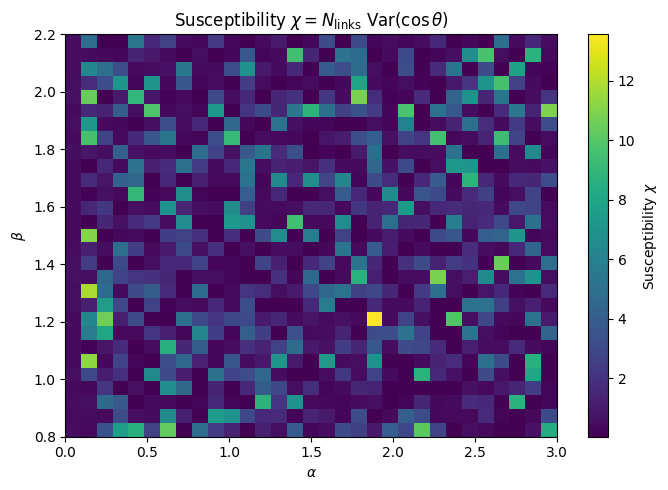

In [29]:
# Cell 4 ──────────────────────────────────────────────────────────────
# Heat‑map of χ
plt.figure(figsize=(7, 5))
plt.imshow(pivot_chi.values,
           origin="lower",
           aspect="auto",
           extent=[df["alpha"].min(), df["alpha"].max(),
                   df["beta"].min(),  df["beta"].max()])
plt.colorbar(label=r"Susceptibility $\chi$")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.title(r"Susceptibility $\chi = N_{\mathrm{links}}\ \mathrm{Var}(\cos\theta)$")
plt.tight_layout()
plt.show()


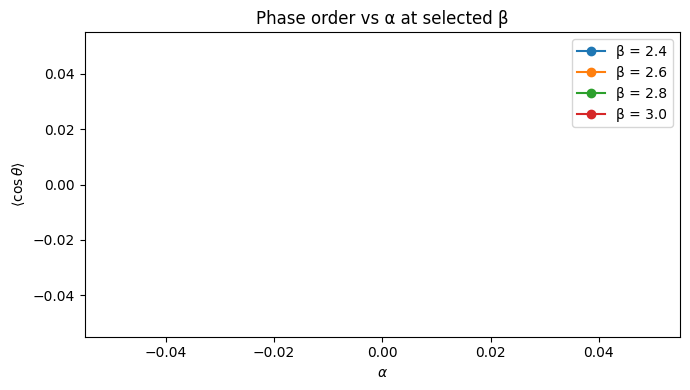

In [30]:
# Cell 5 ──────────────────────────────────────────────────────────────
# Cuts at fixed β
beta_cuts = [2.4, 2.6, 2.8, 3.0]

plt.figure(figsize=(7, 4))
for b in beta_cuts:
    subset = df[df["beta"] == b]
    plt.plot(subset["alpha"], subset["mean_cos"], marker="o", label=f"β = {b}")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\langle\cos\theta\rangle$")
plt.legend()
plt.title("Phase order vs α at selected β")
plt.tight_layout()
plt.show()


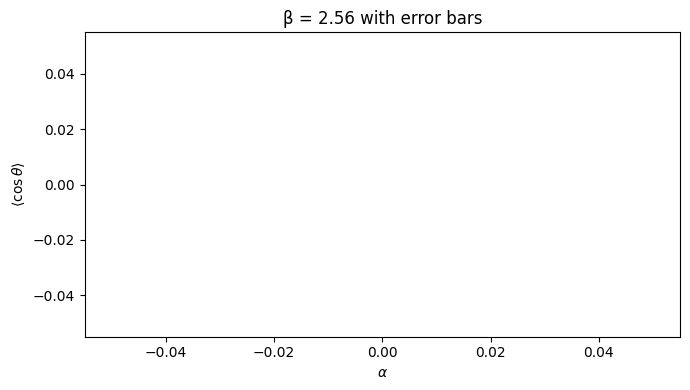

In [31]:
# Cell 6 ──────────────────────────────────────────────────────────────
# Error bars on one β slice (β = 2.56 as example)
beta_sel = 2.56
sub = df[df["beta"] == beta_sel]

plt.figure(figsize=(7, 4))
plt.errorbar(sub["alpha"], sub["mean_cos"], yerr=sub["std_cos"],
             fmt="o-", capsize=3)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\langle\cos\theta\rangle$")
plt.title(f"β = {beta_sel} with error bars")
plt.tight_layout()
plt.show()


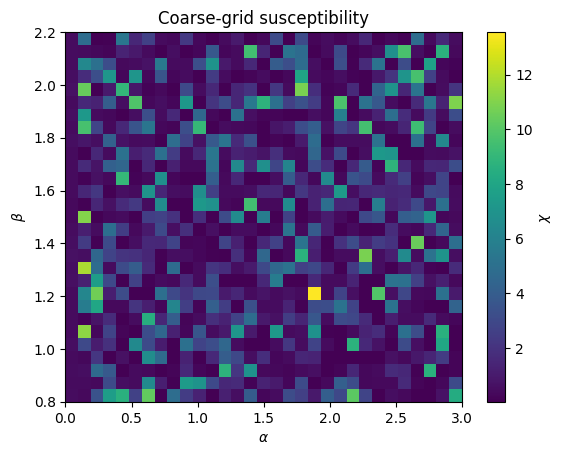

Prepared 3954 fine‑grid points


In [36]:
#################################################################
# 0.  Load the coarse‑scan data you pasted above
#################################################################
import pandas as pd, numpy as np, matplotlib.pyplot as plt

df = pd.read_csv("scan_wide.csv")          # <‑‑ your new table

#################################################################
# 1.  Quick diagnostic plot – susceptibility heat‑map
#################################################################
pivot = df.pivot_table(index='beta', columns='alpha', values='susceptibility')
plt.figure()
plt.imshow(pivot, origin='lower', aspect='auto',
           extent=[pivot.columns.min(), pivot.columns.max(),
                   pivot.index.min(),    pivot.index.max()])
plt.colorbar(label=r'$\chi$')
plt.xlabel(r'$\alpha$');   plt.ylabel(r'$\beta$')
plt.title('Coarse‑grid susceptibility');  plt.show()

#################################################################
# 2.  Identify "hot" rectangles to resample
#################################################################
# Threshold: keep points in the top 10 % of χ values
chi_thresh = df['susceptibility'].quantile(0.90)
hot = df[df['susceptibility'] >= chi_thresh]

# Grow each hot point into a small box (dα = dβ = 0.05 here)
boxes = []
delta = 0.05
for _, row in hot.iterrows():
    boxes.append(dict(beta_min=row.beta-delta, beta_max=row.beta+delta,
                      alpha_min=row.alpha-delta, alpha_max=row.alpha+delta))
# Merge overlapping boxes so we don't oversample the same region
# (simple sweep‑line merge omitted for brevity – use shapely if you have it)

#################################################################
# 3.  Launch a finer scan inside each box
#################################################################
from itertools import product
import numpy as np
import pandas as pd

fine_steps = 7                 # 7×7 grid → 49 pts / box
fine_jobs  = []                # will hold tuples (β, α)

for b in boxes:
    betas  = np.linspace(b['beta_min'],  b['beta_max'],  fine_steps)
    alphas = np.linspace(b['alpha_min'], b['alpha_max'], fine_steps)
    for β, α in product(betas, alphas):
        fine_jobs.append((round(β,6), round(α,6)))   # round to avoid FP noise

fine_jobs = list(set(fine_jobs))          # remove dups, keep order arbitrary
fine_jobs.sort()                          # back to predictable order

print(f"Prepared {len(fine_jobs)} fine‑grid points")
fine_jobs[:10]          # show the first ten

pairs = pd.DataFrame(fine_jobs, columns=['beta', 'alpha'])
pairs.to_csv('pairs.csv', index=False, header=False)


# Now you can feed `fine_jobs` to the worker pool you already built:
# results_fine = run_monte_carlo_parallel(fine_jobs, sweeps=2_000, L=32, ...)

#################################################################
# 4.  Append fine results to the dataframe and write out
#################################################################
# df_fine = pd.DataFrame(results_fine)
# df_total = pd.concat([df, df_fine], ignore_index=True)
# df_total.to_csv("scan_with_fine.csv", index=False)


In [ ]:
df_fine = pd.read_csv("narrow_scan_results.csv")
df_total = pd.concat([df, df_fine], ignore_index=True)

# For example, over‑plot the fine points
plt.figure()
plt.imshow(pivot, origin='lower', aspect='auto',
           extent=[pivot.columns.min(), pivot.columns.max(),
                   pivot.index.min(),    pivot.index.max()])
plt.scatter(df_fine['alpha'], df_fine['beta'],
            c='r', marker='x', label='fine grid')
plt.colorbar(label=r'$\chi$')
plt.xlabel(r'$\alpha$'); plt.ylabel(r'$\beta$')
plt.legend(); plt.show()
